# 로컬 개발 코드
- 로컬에서 주피터 노트북(Jupyter Notebook), 주피터 랩(JupyterLab) 또는 파이썬(Python)을 이용한다. 
- 사이킷 런(scikit-learn), 텐서플로우(tensorflow), 파이토치(pytorch)를 사용하여 딥러닝 프로그램을 개발한다.
- 파일명: 0_local_Perspecive_NewsRec.ipynb

### 로컬 개발 워크플로우(workflow)  
- 로컬 개발 워크플로우를 다음의 4단계로 분리한다.

1. 데이터 세트 준비(Data Setup)
- 로컬 저장소에서 전처리 및 학습에 필요한 학습 데이터 세트를 준비한다.

2. 데이터 전처리(Data Preprocessing)
- 데이터 세트의 분석 및 정규화(Normalization)등의 전처리를 수행한다.
- 데이터를 모델 학습에 사용할 수 있도록 가공한다.
- 추론과정에서 필요한 경우, 데이터 전처리에 사용된 객체를 meta_data 폴더 아래에 저장한다.

3. 학습 모델 훈련(Train Model)
- 데이터를 훈련에 사용할 수 있도록 가공한 뒤에 학습 모델을 구성한다. 
- 학습 모델을 준비된 데이터 세트로 훈련시킨다.
- 정확도(Accuracy)나 손실(Loss)등 학습 모델의 성능을 검증한다.
- 학습 모델의 성능 검증 후, 학습 모델을 배포한다.
- 배포할 학습 모델을 meta_data 폴더 아래에 저장한다.

4. 추론(Inference)
- 저장된 전처리 객체나 학습 모델 객체를 준비한다.
- 추론에 필요한 테스트 데이터 세트를 준비한다.
- 배포된 학습 모델을 통해 테스트 데이터에 대한 추론을 진행한다. 

In [1]:
pip list

Package                  Version
------------------------ ------------
absl-py                  2.1.0
aiohttp                  3.9.5
aiosignal                1.3.1
async-timeout            4.0.3
bertopic                 0.16.2
bidict                   0.23.1
bs4                      0.0.2
click                    8.1.7
cmudict                  1.0.25
Cython                   0.29.37
Distance                 0.1.3
emoji                    1.2.0
faiss-gpu                1.7.2
filelock                 3.13.1
frozenlist               1.4.1
fsspec                   2024.2.0
future                   1.0.0
grpcio                   1.64.1
hangul-jamo              1.0.1
hdbscan                  0.8.37
huggingface-hub          0.23.4
importlib_metadata       8.0.0
importlib_resources      6.4.0
iniconfig                2.0.0
jamo                     0.4.1
joblib                   1.4.2
kollocate                0.0.2
koparadigm               0.10.0
kss                      6.0.4
lightning-utiliti

## 뉴스에 반하다
- 이슈성 정보를 다루는 뉴스에서 기존 관점 다른 관점을 제공해 주어 확증 편향을 완화
- 비판적인 사고력과 자기 객관화 능력 및 정보 분별력 등의 능력 신장에 도움을 주는 프로그램 구축을 목표로 함.

### 사용할 데이터
- (기존)매일 22시마다 기사 자동 수집 -> (변경: 고정 DB 사용) 민희진, 밀양사적제재, 북한 오물풍선, 의사 파업, 25만원 총 5개의 키워드로 각각 크롤링한 뉴스 (총 6437개)
- json 파일(기사 데이터), npy 파일 (임베딩 데이터)
- 문서 요약 데이터 (AI-HUB 제공)

### 사용할 요소
- 뉴스 제목, 링크, 기사본문
- 요약모델 훈련을 위해 문서 요약 데이터 사용
- 수집한 기사 본문 바탕으로 요약문장 뽑아내기.

In [2]:
# Imports
import zipfile
import numpy as np
import json
 
import pandas as pd
from sklearn.model_selection import train_test_split


import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from torch.nn.init import xavier_uniform_

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

import kss


from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import faiss

import requests
from bs4 import BeautifulSoup
import re

/home/jovyan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]


## **1. 데이터셋 준비(Data Setup)**

In [3]:
# dataset.zip 파일 압축 풀기
zip_source_path = './dataset.zip'
zip_target_path = './meta_data'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

### 뉴스 데이터셋

In [4]:
my_path = './meta_data/dataset/'

# 뉴스 데이터셋
dataset='news.json'
news_dataset=pd.read_json(my_path+dataset)

In [5]:
# 뉴스 기사 예시 5개
news_dataset.sample(5)

,index,title,link,article
1979,1979,영동 야산서 발견된 북한 오물 풍선,https://n.news.naver.com/mnews/article/003/001...,안성수 기자 9일 낮 12시29분 충북 영동군 황간면 인근 야산 중턱에서 북한 ...
4470,4470,"세브란스도 멈춘다…환자들 ""고소·고발 불사""",https://n.news.naver.com/mnews/article/009/000...,◆ 의정갈등 ◆서울대병원에 이어 세브란스병원도 '무기한 휴진'을 결정했다. 또 서울...
4812,4812,"사직 전공의 “의대 증원, 의료 위기 해결 못해”…전세계 의사에 호소",https://n.news.naver.com/mnews/article/056/001...,병원을 집단 사직한 전공의들이 세계의사회 행사에서 정부의 의대 증원 정책을 강하게 ...
4036,4036,"한덕수 총리 ""의사협회 총파업 예고, 깊은 유감""",https://n.news.naver.com/mnews/article/421/000...,박정호 기자 한덕수 국무총리가 9일 오후 서울 종로구 세종대로 정부서울청사에서 ...
5159,5159,한국 의료 현실과 성수동의 공통점은?,https://n.news.naver.com/mnews/article/036/000...,성수의원은 요즘 서울 최고의 핫플레이스라는 성동구 성수동에 있는 가정의학과 의원이다...


In [6]:
print("( 뉴스기사 수 , 컬럼 수)")
print(news_dataset.shape)

( 뉴스기사 수 , 컬럼 수)
(6437, 4)


### 저장된 뉴스들의 요약 임베딩 데이터

In [7]:
# 뉴스 요약 임베딩 데이터
dataset='summary_embedding.npy'
summary_embedding_dataset=np.load(my_path+dataset)

In [8]:
print("( 뉴스 개수 ,임베딩 차원 )")
summary_embedding_dataset.shape

( 뉴스 개수 ,임베딩 차원 )


(6437, 128)

In [9]:
summary_embedding_dataset[0] # 첫 번째 기사의 요약 임베딩 데이터

array([-2.80979604e-01,  6.20539337e-02, -6.83445334e-02, -1.19693622e-01,
        2.08823726e-01, -1.24537600e-02,  1.18500881e-01,  2.92633682e-01,
        1.27883732e-01, -1.22530796e-01,  1.88773751e-01,  1.58757374e-01,
        7.53097832e-02,  9.50985700e-02,  1.99547485e-02,  1.87469363e-01,
        2.95771599e-01,  9.03890282e-02,  1.81211784e-01,  5.51250339e-01,
        4.68128473e-02, -1.96054339e-01, -2.05385476e-01,  2.59385973e-01,
       -2.40323737e-01, -1.36626616e-01,  4.44304973e-01, -2.42111281e-01,
       -4.77627926e-02,  2.79585384e-02, -3.09917122e-01,  1.79996401e-01,
        1.54761756e-02, -1.70492396e-01, -3.24941099e-01, -8.85238275e-02,
        1.71700209e-01, -1.93334967e-02,  1.79288030e-01, -4.81512427e-01,
        1.27589509e-01,  7.58003443e-05, -2.44617552e-01, -4.17773165e-02,
       -1.59207672e-01,  2.16412395e-02,  2.14116201e-01,  9.37071070e-02,
       -2.15679660e-01, -1.72768682e-01,  2.53318340e-01, -1.23410642e-01,
       -2.44821072e-01, -

### 저장된 뉴스들의 단락 데이터
- index: 기사 번호
- paragraph: 단락

In [10]:
# 저장된 기사들의 단락 데이터
dataset='paragraph_data.json'
paragraph_dataset=pd.read_json(my_path+dataset)

In [11]:
paragraph_dataset

,index,paragraph
0,0,과거에 비해 다소 살이 빠진 듯한 방시혁 하이브 의장의 모습이 소셜미디어(sns) ...
1,0,방 의장은 전날 자신의 인스타그램 계정에 진과 함께 찍은 사진을 공개하며 “성공적인...
2,0,"이날 개최한 팬 이벤트는 진의 전역 후 첫 행사이자, bts의 데뷔 11주년 행사였..."
3,0,방시혁 하이브 의장이 지난달 28일 오후 무함마드 빈 자예드 알 나흐얀 아랍에미리트...
4,0,줄곧 침묵을 유지하던 방 의장은 지난달 17일 법원에 제출한 탄원서를 통해 “한 사...
...,...,...
33648,6435,이 대표는 경남 창원 민주당 경남도당에서 열린 현장 선거대책위원회에서 같은 당 김경...
33649,6435,이 대표는 전날 자신이 내놓은 ‘국민 1인당 25만원씩(총 13조원 추산) 민생회복...
33650,6435,"국민의힘은 세 자녀 등록금 면제 대상은 34만명이고, 들어갈 예산은 1조4500억원..."
33651,6435,"세 자녀 가구에 지원되는 전기요금, 도시가스, 지역난방비 감면을 두 자녀 가구로 확..."


In [12]:
print("( 단락 총 개수 , 컬럼 수)")
paragraph_dataset.shape

( 단락 총 개수 , 컬럼 수)


(33653, 2)

### 저장된 뉴스들의 단락 임베딩 데이터

In [13]:
# 저장된 기사들의 단락 임베딩 데이터
dataset='paragraph_embedding.npy'
paragraph_embedding_dataset=np.load(my_path+dataset)

In [14]:
print("( 단락 총 개수 , 임베딩 차원 )")
paragraph_embedding_dataset.shape

( 단락 총 개수 , 임베딩 차원 )


(33653, 128)

In [15]:
print(paragraph_embedding_dataset[0])# 첫번째 기사의 1번 단락 임베딩 데이터

[-3.27881664e-01  1.14686206e-01 -3.37897390e-02 -1.89114317e-01
  2.53429800e-01  5.00494204e-02  1.96555123e-01  2.81413555e-01
  1.71784639e-01 -1.66616380e-01  2.19282180e-01  1.76256597e-01
 -7.33617367e-03  2.34767750e-01  5.44347195e-03  4.07325588e-02
  1.38898820e-01  1.18467353e-01  3.30788307e-02  5.21330237e-01
  1.35957694e-03 -1.89961404e-01 -1.63521573e-01  2.78955787e-01
 -2.86507934e-01 -2.54717767e-01  4.47581232e-01 -1.88536391e-01
 -8.64003524e-02  1.46690339e-01 -2.52024174e-01  2.27498025e-01
  9.02265385e-02 -9.52593833e-02 -3.43573064e-01 -6.72127530e-02
  1.05423577e-01  1.75513811e-02  1.22265011e-01 -4.44901586e-01
  1.70518607e-01 -1.24860844e-02 -2.04270840e-01 -1.10439554e-01
 -1.18234046e-02  7.24388808e-02  2.57121265e-01  8.17412436e-02
 -1.05895422e-01 -1.48167774e-01  1.48221895e-01  4.64897156e-02
 -5.93772121e-02 -3.49758297e-01 -2.06938535e-01  1.65401340e-01
 -7.27411285e-02 -3.06901336e-02 -1.07786343e-01 -9.71050113e-02
  1.97121829e-01  3.32890

### 요약 모델 훈련을 위한 데이터셋
- AI Hub 문서요약텍스트 데이터셋 (신문 기사 데이터셋)
- https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=97

In [16]:
# train / valid dataset
train_dataset=pd.read_json(my_path+'train_original.json')
valid_dataset=pd.read_json(my_path+'valid_original.json')

In [17]:
valid_dataset

,name,delivery_date,documents
0,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '340626877', 'category': '정치', 'media_t..."
1,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '340626896', 'category': '종합', 'media_t..."
2,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '340626904', 'category': 'IT,과학', 'medi..."
3,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '340627450', 'category': '사회', 'media_t..."
4,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '340627465', 'category': '경제', 'media_t..."
...,...,...,...
30117,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '350851474', 'category': '종합', 'media_t..."
30118,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '350851925', 'category': '경제', 'media_t..."
30119,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '350854748', 'category': '종합', 'media_t..."
30120,문서요약 프로젝트,2020-12-23 12:01:15,"{'id': '350857648', 'category': '종합', 'media_t..."


## **2. 데이터 전처리 (Data Preprocessing)**

### 데이터 준비 (Preparing Data)
요약모델을 위한 데이터셋을 훈련에 사용할 수 있는 형태로 변형

- 결측 데이터 삭제
- 훈련/테스트 데이터셋을 9.5:0.5 비율로 나눔
- 기존 데이터셋이었던 Bflysoft에서 제공한 뉴스 데이터가 비공개처리 되어 대체 데이터셋인 AI-HUB 문서 요약 데이터셋을 기존 데이터셋처럼 변형

#### 결측 데이터 삭제

In [18]:
train_dataset=train_dataset.dropna()
print("train_dataset 수:"+str(len(train_dataset)))

valid_dataset=valid_dataset.dropna()
print("valid_dataset 수:"+str(len(valid_dataset)))

train_dataset 수:243983
valid_dataset 수:30122


# 훈련 & 평가 데이터셋 생성

훈련 데이터셋에서 0.05를 valid 데이터셋으로 사용 (https://github.com/KPFBERT/kpfbertsum/blob/main/kpfbert_summary.ipynb)

In [19]:
train_df, val_df=train_test_split(train_dataset, test_size=0.05)
test_df=valid_dataset
train_df=train_df.reset_index(drop=True)
val_df=val_df.reset_index(drop=True)

In [20]:
print("( 훈련 데이터 개수 , 검증 데이터 수, 테스트 데이터 수)")
print(train_df.shape, val_df.shape, test_df.shape)

( 훈련 데이터 개수 , 검증 데이터 수, 테스트 데이터 수)
(231783, 3) (12200, 3) (30122, 3)


#### 기존 Bflysoft-뉴스기사 데이터셋에 맞춰 변환
- 기존에 Bflysoft-뉴스기사 데이터셋에 맞춰 작성된 코드이나 해당 데이터셋이 비공개되어 AI-HUB 데이터셋을 변형시켜 사용

In [21]:
def preprocess_data(data):
    outs = []
    for doc in data['documents']:
        line = []
        line.append(doc['media_name'])
        line.append(doc['id'])
        para = []
        for sent in doc['text']:
            for s in sent:
                para.append(s['sentence'])
        line.append(para)
        line.append(doc['abstractive'][0])
        line.append(doc['extractive'])
        a = doc['extractive']
        if a[0] == None or a[1] == None or a[2] == None:
            continue
        outs.append(line)

    outs_df = pd.DataFrame(outs)
    outs_df.columns = ['media', 'id', 'article_original', 'abstractive', 'extractive']
    return outs_df

In [22]:
train_df = preprocess_data(train_df)
train_df.head(1)

,media,id,article_original,abstractive,extractive
0,이데일리,335378515,[주연테크(044380)는 최신 엔비디아 지포스 RTX 그래픽카드를 탑재한 '리오나...,25일 주연테크는 엔비디아 지포스 RTX2060와 RTX2070 Max-Q의 그래픽...,"[0, 2, 4]"


In [23]:
test_df = preprocess_data(test_df)
test_df.head(1)

,media,id,article_original,abstractive,extractive
0,한국경제,340626877,"[[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 ""넓고, ...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...,"[0, 1, 3]"


In [24]:
val_df = preprocess_data(val_df)
val_df.head(1)

,media,id,article_original,abstractive,extractive
0,전라일보,353958386,"[비공개 최고위원 간담회 열고 위원회 구성·총선 전략 논의, 김형민 기자l jal7...",복수의 민주당 관계자들에 따르면 이해찬 대표 등 당 지도부는 내년 4월 총선을 대비...,"[2, 5, 14]"


In [25]:
# 빠른 훈련을 위해 데이터셋 줄임
train_df=train_df.sample(frac=0.05)
test_df=test_df.sample(frac=0.05)
val_df=val_df.sample(frac=0.05)

## **3. 학습 모델 훈련 (Train Model)**
요약 모델 훈련

In [26]:
RANDOM_SEED = 42

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [27]:
BERT_MODEL_NAME = 'jinmang2/kpfbert'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [28]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 10
BATCH_SIZE = 4

bert에서 여러문장을 입력하기 위해 presumm 에서 제안한 형식으로 인코딩 한다.

- token embedding : < CLS > 문장 < SEP > 문장 < SEP > 문장 ... 문장 < SEP >
- interval segment : 0 , 0 , 0 , 1 , 1 , 0 , 0 , ... 1 , 1
- position embedding : 1 , 1 , 1 , 1 , 1 , 1 , 1 , ... 1 , 1

[입력 전처리]
- 문장 분리
- BERT 입력 형식 변환
- 입력 시퀀스 생성

[BERT 인코더]
- 문장 인코딩
- 문맥 정보 포함

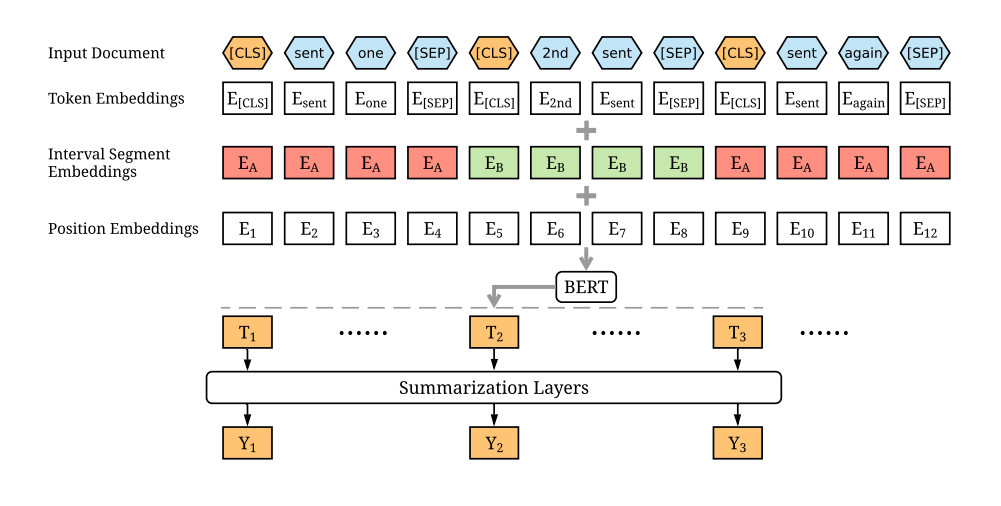

In [29]:
# Dataset을 BERT 모델을 이용하여 문장을 인코딩함
class SummDataset(Dataset):

    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: BertTokenizer, # BERTokenizer로 토큰화
        max_token_len: int = 512 # 최대 길이 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        tokenlist = []
        for sent in data_row.article_original:
            tokenlist.append(tokenizer(
                text = sent,
                add_special_tokens = True)) #, # Add '[CLS]' and '[SEP]'
    
        src = [] # 토크나이징 된 전체 문단
        labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
        segs = []  #각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
        clss = []  #[CLS]토큰의 포지션값을 지정

        odd = 0
        for tkns in tokenlist:
            if odd > 1 : odd = 0
            clss = clss + [len(src)]
            src = src + tkns['input_ids']
            segs = segs + [odd] * len(tkns['input_ids'])
            if tokenlist.index(tkns) in data_row.extractive :
                labels = labels + [1]
            else:
                labels = labels + [0]
            odd += 1
        
            #truncation
            if len(src) == MAX_TOKEN_COUNT:
                break
            elif len(src) > MAX_TOKEN_COUNT:
                src = src[:self.max_token_len - 1] + [src[-1]]
                segs = segs[:self.max_token_len]
                break
    
        #padding
        if len(src) < MAX_TOKEN_COUNT:
            src = src + [0]*(self.max_token_len - len(src))
            segs = segs + [0]*(self.max_token_len - len(segs))
            
        if len(clss) < MAX_TOKEN_COUNT:
            clss = clss + [-1]*(self.max_token_len - len(clss))
        if len(labels) < MAX_TOKEN_COUNT:
            labels = labels + [0]*(self.max_token_len - len(labels))

        return dict(
            src = torch.tensor(src),
            segs = torch.tensor(segs),
            clss = torch.tensor(clss),
            labels= torch.FloatTensor(labels)
        )


# 데이터셋을 SummDataset 함수를 이용하여 모델 입력으로 들어가도록 변환
# 이를 하나의 DataModule로 만든다.
class SummDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, val_df, tokenizer, batch_size=1, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    # SummDataset을 이용하여 dataset을 요약모델 입력으로 들어가도록 변환
    def setup(self, stage=None):
        self.train_dataset = SummDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = SummDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
    
        self.val_dataset = SummDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0 # windows는 0으로 고정해야 에러 안난다. num_workers=2
        )
data_module = SummDataModule(
  train_df,
  test_df,  
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## MODEL
kpfBERT를 pretrained_bert로 불러와서 후처리 레이어를 추가하여 문장추출 모델을 만든다.

### PreSumm (추출요약 ver.)
[문장 중요도 예측]
- 문장의 벡터 표현을 입력으로 받아서, 각 문장이 요약문에 포함될 확률 예측

[문장 선택]
- 상위 문장을 선택하여 요약문 구성(3문장)

[모델 구조]
- PositionalEncoding: 입력 문장의 위치 정보를 추가 -> 모델이 문장 내 단어의 상대적 위치를 인식, self-Attention의 문맥 이해 향상
- TransformerEncoderLayer:  Transformer 인코더 레이어를 정의
- ExtTransformerEncoder: 여러 Transformer 인코더 레이어를 쌓아 확장된 Transformer 인코더를 정의
- PositionwiseFeedForward: 두 개의 선형 레이어와 잔차 연결을 사용하는 FeedFoward 정의
- MultiHeadedAttention: 여러 관점에서의 Self-Attention 수행 -> 문맥 이해 향상
- Summarizer: 전체 요약 모델을 정의

In [30]:
class PositionalEncoding(nn.Module):

    def __init__(self, dropout, dim, max_len=5000):
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) *
                              -(math.log(10000.0) / dim)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)
        self.dim = dim

    def forward(self, emb, step=None):
        emb = emb * math.sqrt(self.dim)
        if (step):
            emb = emb + self.pe[:, step][:, None, :]

        else:
            emb = emb + self.pe[:, :emb.size(1)]
        emb = self.dropout(emb)
        return emb

    def get_emb(self, emb):
        return self.pe[:, :emb.size(1)]
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout):
        super(TransformerEncoderLayer, self).__init__()

        self.self_attn = MultiHeadedAttention(
            heads, d_model, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, iter, query, inputs, mask):
        if (iter != 0):
            input_norm = self.layer_norm(inputs)
        else:
            input_norm = inputs

        mask = mask.unsqueeze(1)
        context = self.self_attn(input_norm, input_norm, input_norm,
                                 mask=mask)
        out = self.dropout(context) + inputs
        return self.feed_forward(out)
class ExtTransformerEncoder(nn.Module):
    def __init__(self, hidden_size=768, d_ff=2048, heads=8, dropout=0.2, num_inter_layers=2):
        super(ExtTransformerEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_inter_layers = num_inter_layers
        self.pos_emb = PositionalEncoding(dropout, hidden_size)
        self.transformer_inter = nn.ModuleList(
            [TransformerEncoderLayer(hidden_size, heads, d_ff, dropout)
            for _ in range(num_inter_layers)])
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.wo = nn.Linear(hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, top_vecs, mask):
        """ See :obj:`EncoderBase.forward()`"""

        batch_size, n_sents = top_vecs.size(0), top_vecs.size(1)
        pos_emb = self.pos_emb.pe[:, :n_sents]
        x = top_vecs * mask[:, :, None].float()
        x = x + pos_emb

        for i in range(self.num_inter_layers):
            x = self.transformer_inter[i](i, x, x, ~mask) 

        x = self.layer_norm(x)
        sent_scores = self.sigmoid(self.wo(x))
        sent_scores = sent_scores.squeeze(-1) * mask.float()

        return sent_scores
class PositionwiseFeedForward(nn.Module):
    """ A two-layer Feed-Forward-Network with residual layer norm.

    Args:
        d_model (int): the size of input for the first-layer of the FFN.
        d_ff (int): the hidden layer size of the second-layer
            of the FNN.
        dropout (float): dropout probability in :math:`[0, 1)`.
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def gelu(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


    def forward(self, x):
        inter = self.dropout_1(self.gelu(self.w_1(self.layer_norm(x))))
        output = self.dropout_2(self.w_2(inter))
        return output + x
class MultiHeadedAttention(nn.Module):
    """
    Multi-Head Attention module from
    "Attention is All You Need"
    :cite:`DBLP:journals/corr/VaswaniSPUJGKP17`.

    Similar to standard `dot` attention but uses
    multiple attention distributions simulataneously
    to select relevant items.

    .. mermaid::

       graph BT
          A[key]
          B[value]
          C[query]
          O[output]
          subgraph Attn
            D[Attn 1]
            E[Attn 2]
            F[Attn N]
          end
          A --> D
          C --> D
          A --> E
          C --> E
          A --> F
          C --> F
          D --> O
          E --> O
          F --> O
          B --> O

    Also includes several additional tricks.

    Args:
       head_count (int): number of parallel heads
       model_dim (int): the dimension of keys/values/queries,
           must be divisible by head_count
       dropout (float): dropout parameter
    """

    def __init__(self, head_count, model_dim, dropout=0.1, use_final_linear=True):
        assert model_dim % head_count == 0
        self.dim_per_head = model_dim // head_count
        self.model_dim = model_dim

        super(MultiHeadedAttention, self).__init__()
        self.head_count = head_count

        self.linear_keys = nn.Linear(model_dim,
                                     head_count * self.dim_per_head)
        self.linear_values = nn.Linear(model_dim,
                                       head_count * self.dim_per_head)
        self.linear_query = nn.Linear(model_dim,
                                      head_count * self.dim_per_head)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.use_final_linear = use_final_linear
        if (self.use_final_linear):
            self.final_linear = nn.Linear(model_dim, model_dim)

    def forward(self, key, value, query, mask=None,
                layer_cache=None, type=None, predefined_graph_1=None):
        """
        Compute the context vector and the attention vectors.

        Args:
           key (`FloatTensor`): set of `key_len`
                key vectors `[batch, key_len, dim]`
           value (`FloatTensor`): set of `key_len`
                value vectors `[batch, key_len, dim]`
           query (`FloatTensor`): set of `query_len`
                 query vectors  `[batch, query_len, dim]`
           mask: binary mask indicating which keys have
                 non-zero attention `[batch, query_len, key_len]`
        Returns:
           (`FloatTensor`, `FloatTensor`) :

           * output context vectors `[batch, query_len, dim]`
           * one of the attention vectors `[batch, query_len, key_len]`
        """

        batch_size = key.size(0)
        dim_per_head = self.dim_per_head
        head_count = self.head_count
        key_len = key.size(1)
        query_len = query.size(1)

        def shape(x):
            """  projection """
            return x.view(batch_size, -1, head_count, dim_per_head) \
                .transpose(1, 2)

        def unshape(x):
            """  compute context """
            return x.transpose(1, 2).contiguous() \
                .view(batch_size, -1, head_count * dim_per_head)

        # 1) Project key, value, and query.
        if layer_cache is not None:
            if type == "self":
                query, key, value = self.linear_query(query), \
                                    self.linear_keys(query), \
                                    self.linear_values(query)

                key = shape(key)
                value = shape(value)

                if layer_cache is not None:
                    device = key.device
                    if layer_cache["self_keys"] is not None:
                        key = torch.cat(
                            (layer_cache["self_keys"].to(device), key),
                            dim=2)
                    if layer_cache["self_values"] is not None:
                        value = torch.cat(
                            (layer_cache["self_values"].to(device), value),
                            dim=2)
                    layer_cache["self_keys"] = key
                    layer_cache["self_values"] = value
            elif type == "context":
                query = self.linear_query(query)
                if layer_cache is not None:
                    if layer_cache["memory_keys"] is None:
                        key, value = self.linear_keys(key), \
                                     self.linear_values(value)
                        key = shape(key)
                        value = shape(value)
                    else:
                        key, value = layer_cache["memory_keys"], \
                                     layer_cache["memory_values"]
                    layer_cache["memory_keys"] = key
                    layer_cache["memory_values"] = value
                else:
                    key, value = self.linear_keys(key), \
                                 self.linear_values(value)
                    key = shape(key)
                    value = shape(value)
        else:
            key = self.linear_keys(key)
            value = self.linear_values(value)
            query = self.linear_query(query)
            key = shape(key)
            value = shape(value)

        query = shape(query)

        key_len = key.size(2)
        query_len = query.size(2)

        # 2) Calculate and scale scores.
        query = query / math.sqrt(dim_per_head)
        scores = torch.matmul(query, key.transpose(2, 3))

        if mask is not None:
            mask = mask.unsqueeze(1).expand_as(scores)
            scores = scores.masked_fill(mask, -1e18) # how can i fix it to use fp16...

        # 3) Apply attention dropout and compute context vectors.

        attn = self.softmax(scores)

        if (not predefined_graph_1 is None):
            attn_masked = attn[:, -1] * predefined_graph_1
            attn_masked = attn_masked / (torch.sum(attn_masked, 2).unsqueeze(2) + 1e-9)

            attn = torch.cat([attn[:, :-1], attn_masked.unsqueeze(1)], 1)

        drop_attn = self.dropout(attn)
        if (self.use_final_linear):
            context = unshape(torch.matmul(drop_attn, value))
            output = self.final_linear(context)
            return output
        else:
            context = torch.matmul(drop_attn, value)
            return context

class Summarizer(pl.LightningModule):

    def __init__(self, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.max_pos = 512
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME) #, return_dict=True)
        self.ext_layer = ExtTransformerEncoder()
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss = nn.BCELoss(reduction='none')
    
        for p in self.ext_layer.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

    def forward(self, src, segs, clss, labels=None): #, input_ids, attention_mask, labels=None):
        
        mask_src = ~(src == 0) #1 - (src == 0)
        mask_cls = ~(clss == -1) #1 - (clss == -1)

        top_vec = self.bert(src, token_type_ids=segs, attention_mask=mask_src)
        top_vec = top_vec.last_hidden_state
        
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]
        sents_vec = sents_vec * mask_cls[:, :, None].float()

        sent_scores = self.ext_layer(sents_vec, mask_cls).squeeze(-1)
        
        loss = 0
        if labels is not None:
            loss = self.loss(sent_scores, labels)
            
            loss = (loss * mask_cls.float()).sum() / len(labels)
        
        return loss, sent_scores
    
    def step(self, batch):

        src = batch['src']
        if len(batch['labels']) > 0 :
            labels = batch['labels']
        else:
            labels = None
        segs = batch['segs']
        clss = batch['clss']
        
        loss, sent_scores = self(src, segs, clss, labels)    
        
        return loss, sent_scores, labels

    def training_step(self, batch, batch_idx):

        loss, sent_scores, labels = self.step(batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def validation_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def test_step(self, batch, batch_idx):
        
        loss, sent_scores, labels = self.step(batch)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": sent_scores, "labels": labels}

    def acc_loss(self, outputs):
        total_loss = 0
        hit_cnt = 0
        for outp in outputs:
            labels = outp['labels'].cpu()
            predictions, idxs = outp['predictions'].cpu().sort()
            loss = outp['loss'].cpu()
            for label, idx in zip(labels, idxs):
                for i in range(1,3):
                    if label[idx[-i-1]] == 1 : 
                        hit_cnt += 1

            total_loss += loss
            
        avg_loss = total_loss / len(outputs)
        acc = hit_cnt / (3*len(outputs)*len(labels))
        
        return acc, avg_loss
        
    def training_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('acc:', acc, 'avg_loss:', avg_loss)
        
        self.log('avg_train_loss', avg_loss, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('val_acc:', acc, 'avg_val_loss:', avg_loss)
        
        self.log('avg_val_loss', avg_loss, prog_bar=True, logger=True)

    def test_epoch_end(self, outputs):
        
        acc, avg_loss = self.acc_loss(outputs)
        
        print('test_acc:', acc, 'avg_test_loss:', avg_loss)
        
        self.log('avg_test_loss', avg_loss, prog_bar=True, logger=True)

        return
        
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr=2e-5)

        steps_per_epoch=len(train_df) // BATCH_SIZE
        total_training_steps = steps_per_epoch * N_EPOCHS
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=steps_per_epoch,
            num_training_steps=total_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

### 모델 컴파일 및 학습 (Compile and Train Model)

- Fine Tuning
- 가장 최적의 결과를 낸 모델을 checkpoints/best-checkpoint.ckpt 로 저장
- lightning_logs/kpfBERT_Summary/version_x/ 하위에 fine-tuning 로그가 저장됨, x는 실행순서 번호

In [31]:
model = Summarizer()

Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="avg_val_loss",
    mode="min"
)

In [33]:
logger = TensorBoardLogger("lightning_logs", name="kpfBERT_Summary")


In [34]:
early_stopping_callback = EarlyStopping(monitor='avg_val_loss', patience=3)


In [35]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    #progress_bar_refresh_rate=30
#     precision=16, #소스 수정 또는 패키지 재설치 필요... 런타임 에러.
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [36]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | bert      | BertModel             | 114 M 
1 | ext_layer | ExtTransformerEncoder | 11.0 M
2 | loss      | BCELoss               | 0     
----------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
500.230   Total estimated model params size (MB)


Epoch 0:  89%|████████▊ | 2899/3275 [07:09<00:55,  6.74it/s, loss=4.63, v_num=1, val_loss=23.40, avg_val_loss=23.40, train_loss=3.020]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 3275/3275 [07:33<00:00,  7.22it/s, loss=4.63, v_num=1, val_loss=4.450, avg_val_loss=4.440, train_loss=3.320, avg_train_loss=5.250]
                                                             

Epoch 0, global step 2897: avg_val_loss reached 4.44431 (best 4.44431), saving model to "checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1:  89%|████████▊ | 2899/3275 [07:03<00:54,  6.84it/s, loss=4.04, v_num=1, val_loss=4.450, avg_val_loss=4.440, train_loss=3.050, avg_train_loss=5.250]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 3275/3275 [07:27<00:00,  7.32it/s, loss=4.04, v_num=1, val_loss=4.550, avg_val_loss=4.550, train_loss=2.690, avg_train_loss=4.220]
                                                             

Epoch 1, step 5795: avg_val_loss was not in top 1


Epoch 2:  88%|████████▊ | 2898/3275 [06:59<00:54,  6.90it/s, loss=3.61, v_num=1, val_loss=4.550, avg_val_loss=4.550, train_loss=4.030, avg_train_loss=4.220]acc: 1.656889809063722 avg_loss: tensor(3.6567)

Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 3275/3275 [07:26<00:00,  7.34it/s, loss=3.61, v_num=1, val_loss=4.620, avg_val_loss=4.620, train_loss=4.890, avg_train_loss=3.660]
                                                             

Epoch 2, step 8693: avg_val_loss was not in top 1


Epoch 3:  88%|████████▊ | 2898/3275 [06:59<00:54,  6.90it/s, loss=2.38, v_num=1, val_loss=4.620, avg_val_loss=4.620, train_loss=3.270, avg_train_loss=3.660]acc: 1.955371520588912 avg_loss: tensor(2.6011)

Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 3275/3275 [07:26<00:00,  7.34it/s, loss=2.38, v_num=1, val_loss=5.690, avg_val_loss=5.680, train_loss=3.710, avg_train_loss=2.600]
                                                             

Epoch 3, step 11591: avg_val_loss was not in top 1


Epoch 3: 100%|██████████| 3275/3275 [07:26<00:00,  7.34it/s, loss=2.38, v_num=1, val_loss=5.690, avg_val_loss=5.680, train_loss=3.710, avg_train_loss=2.600]


1

### 모델 평가 (Evaluate Model)

In [37]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 153/153 [00:09<00:00, 16.81it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': 4.288243770599365, 'test_loss': 4.287829399108887}
--------------------------------------------------------------------------------


[{'test_loss': 4.287829399108887, 'avg_test_loss': 4.288243770599365}]

## **4. 추론 (Inference)**

1. 훈련한 요약 모델을 바탕으로 테스트 뉴스 데이터의 요약본 추출 및 임베딩
3. 피어슨 상관관계를 이용하여 기존 뉴스 요약 임베딩 데이터와 비교 (threshold=0.55)
4. 높은 유사도를 가진 뉴스 데이터(최대 100개)를 추출
5. 테스트 뉴스의 단락 데이터 생성 및 임베딩
6. 저장된 단락 임베딩 데이터와 테스트 뉴스의 단락 데이터를 이용하여 BERTopic으로 클러스터링 진행
7. 클러스터링 결과 바탕으로 다른 뉴스 3개 출력

##### 테스트 데이터셋 불러오기

In [38]:
# dataset.zip 파일을 dataset 폴더에 압축을 풀어준다.
zip_source_path = './test_dataset.zip'
zip_target_path = './meta_data'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

In [6]:
import json

In [13]:
my_path='./meta_data/test_dataset/'

test_name='test.json'
with open(my_path+test_name, encoding='utf8') as f:
    test_dataset = json.load(f)

In [15]:
target_link=test_dataset['data']

In [16]:
target_link

'https://n.news.naver.com/mnews/article/022/0003937314?sid=100'

In [17]:
import requests
from bs4 import BeautifulSoup
import re

#### 기사 링크 바탕으로 기사 본문 크롤링해오기

In [18]:
# 크롤링 함수 추가
def preprocessing(d):  # 한국어 기사 본문 전처리 함수
    d = d.lower()
    d = re.sub(r'[a-z0-9\-_.]{3,}@[a-z0-9\-_.]{3,}(?:[.]?[a-z]{2})+', ' ', d)
    d = re.sub(r'‘’ⓒ\'\"“”…=□*◆:/_]', ' ', d)
    d = re.sub(r'\s+', ' ', d)
    d = re.sub(r'^\s|\s$', '', d)
    d = re.sub(r'[<*>_="/■□▷▶]', '', d)
    return d


def fetch_article_data(article_url):  # 기사 본문, 기자 정보 수집 함수
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    resp = requests.get(article_url, headers=headers)
    if resp.status_code != 200:
        return "Failed to retrieve the article"

    article_dom = BeautifulSoup(resp.content, 'html.parser')

    # 특정 선택자를 사용하여 기사 본문 추출
    content_tag = article_dom.select_one(
        'article#dic_area.go_trans._article_content')

    content = preprocessing(content_tag.get_text(
        strip=True)) if content_tag else ''

    # 기자 정보 추출
    reporter_tag = article_dom.select_one('div.byline span') or \
        article_dom.select_one('p.byline') or \
        article_dom.select_one('span.byline')

    reporter = reporter_tag.get_text(strip=True) if reporter_tag else ''

    article_data = {
        "link": article_url,  # 기사 링크
        "article": content,  # 기사 본문
        "reporter": reporter  # 기자
    }

    return article_data

#### 테스트 뉴스의 본문 

In [19]:
target_data = fetch_article_data(target_link)
target_article = target_data['article']

In [20]:
target_article

'당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련법안 당론 채택 예고더불어민주당 이재명 대표가 민생회복지원금과 관련해 고수해오던 ‘보편 지원’ 주장을 내려놨다. 정부여당을 향해 “차등 지원도 수용하겠다”며 이른 시일 내 협의하자고 제안한 것이다. 하지만 여당은 ‘차등 지원’을 전제로 하더라도 여전히 민생회복지원금 자체에 부정적인 모습이다. 민주당은 4·10 총선 때부터 ‘전 국민 25만원 지급’을 골자로 한 민생회복지원금 제도 시행을 촉구해왔다.이 대표는 29일 당 최고위원회의에서 “민생회복지원금은 소득 지원 효과도 있지만 지역·지방 소비를 늘려서 경제를 활성화하는 경제 정책이다. 반드시 지원해야 한다”며 “골목경제가 살아나면 정부여당 지지율도 올라가고 좋지 않냐”고 말했다.끝까지 대결 정치더불어민주당 이재명 대표(오른쪽)가 29일 서울 여의도 국회에서 열린 최고위원회의에서 윤석열 대통령과 이종섭 전 국방부 장관의 통화 사실을 보도한 자료를 보며 정청래 최고위원과 대화하고 있다. 남제현 선임기자이 대표는 윤석열 대통령과 정부여당을 향해 “우리가 지원금을 반드시 (전 국민에게) 똑같이 지급하라는 주장을 더 이상 하지 않겠다”며 “우리가 지향하는 가치는 보편 지원에 있긴 하지만 굳이 어렵다면 차등 지원도 수용하겠다”고 했다. 그러면서 고소득층 대상 매칭 지원 등 구체적 방안도 제시했다. 이 대표는 그간 고수해온 ‘보편 지원’ 원칙을 철회한 데 대해 “안 하는 것보다 낫기 때문”이라며 “우리가 양보할 테니 경기도 살리고 민생도 살리는 정책을 수용해주시고, 구체적 내용은 신속하게 만나서 협의하면 좋겠다”고 했다.이번 제안은 이 대표의 ‘실용 정치’ 행보의 일환으로 해석된다. 연금개혁안에 이어 민생 관련 사안에 대한 책임정당 모습을 선점하기 위한 포석이기도 하다. 민주당 한민수 대변인은 이날 이 대표 제안에 대해 “이 대표가 연금개혁에 이어 다시 한 번 양보한 안을 냈다”며 “민생과 경제를 책임지는 대통령과 정부여당의 답이 있을 것”

### 요약모델 이용해서 테스트 뉴스의 요약본 추출

In [42]:
# 훈련된 요약 모델 로드
trained_model = Summarizer.load_from_checkpoint(
    'checkpoints/best-checkpoint.ckpt',
    strict=False
)
trained_model.eval()
trained_model.freeze()

# 문장 분리 함수
def data_process(text):
    # 문장 분리 하고,
    sents = kss.split_sentences(text)

    # 데이터 가공하고,
    tokenlist = []
    for sent in sents:
        tokenlist.append(tokenizer(
            text=sent,
            add_special_tokens=True))  # , # Add '[CLS]' and '[SEP]'

    src = []  # 토크나이징 된 전체 문단
    labels = []  # 요약문에 해당하면 1, 아니면 0으로 문장수 만큼 생성
    segs = []  # 각 토큰에 대해 홀수번째 문장이면 0, 짝수번째 문장이면 1을 매핑
    clss = []  # [CLS]토큰의 포지션값을 지정

    odd = 0

    for tkns in tokenlist:

        if odd > 1:
            odd = 0
        clss = clss + [len(src)]
        src = src + tkns['input_ids']
        segs = segs + [odd] * len(tkns['input_ids'])
        odd += 1

        # truncation
        if len(src) == MAX_TOKEN_COUNT:
            break
        elif len(src) > MAX_TOKEN_COUNT:
            src = src[:MAX_TOKEN_COUNT - 1] + [src[-1]]
            segs = segs[:MAX_TOKEN_COUNT]
            break

    # padding
    if len(src) < MAX_TOKEN_COUNT:
        src = src + [0]*(MAX_TOKEN_COUNT - len(src))
        segs = segs + [0]*(MAX_TOKEN_COUNT - len(segs))

    if len(clss) < MAX_TOKEN_COUNT:
        clss = clss + [-1]*(MAX_TOKEN_COUNT - len(clss))

    return dict(
        sents=sents,  # 정답 출력을 위해...
        src=torch.tensor(src),
        segs=torch.tensor(segs),
        clss=torch.tensor(clss),
    )

# 요약본 추출 함수
def summarize_test(text):
    data = data_process(text.replace('\n', ''))

    # trained_model에 넣어 결과값 반환
    _, rtn = trained_model(data['src'].unsqueeze(
        0), data['segs'].unsqueeze(0), data['clss'].unsqueeze(0))
    rtn = rtn.squeeze()

    # 예측 결과값을 받기 위한 프로세스
    rtn_sort, idx = rtn.sort(descending=True)

    rtn_sort = rtn_sort.tolist()
    idx = idx.tolist()

    end_idx = rtn_sort.index(0)

    rtn_sort = rtn_sort[:end_idx]
    idx = idx[:end_idx]

    if len(idx) > 3:
        rslt = idx[:3]
    else:
        rslt = idx

    summ = []
    for i, r in enumerate(rslt):
        summ.append(data['sents'][r])

    return summ

# 요약본 결과 반환
def summarize_article(target_article):
    target_summary = summarize_test(target_article)
    return target_summary


Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
target_summary=summarize_article(target_article)
target_summary=" ".join(target_summary)

[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D



In [44]:
target_summary

'당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련법안 당론 채택 예고더불어민주당 이재명 대표가 민생회복지원금과 관련해 고수해오던 ‘보편 지원’ 주장을 내려놨다. 정부여당을 향해 “차등 지원도 수용하겠다”며 이른 시일 내 협의하자고 제안한 것이다. 하지만 여당은 ‘차등 지원’을 전제로 하더라도 여전히 민생회복지원금 자체에 부정적인 모습이다.'

### 추출한 요약모델 임베딩

In [45]:
model = SentenceTransformer('bongsoo/kpf-sbert-128d-v1')  # 임베딩 모델
model.max_seq_length = 512

In [46]:
target_summary_embedding = model.encode(target_summary,normalize_embeddings=True)

In [47]:
target_summary_embedding.shape

(128,)

### 테스트 요약 임베딩과 수집 기사 요약 임베딩 유사도 비교

In [48]:
# 피어슨 상관계수 구하기
def pearson_similarity(a, b):
    return np.dot((a-np.mean(a)), (b-np.mean(b)))/((np.linalg.norm(a-np.mean(a)))*(np.linalg.norm(b-np.mean(b))))

In [49]:
# 피어슨 상관계수 기반으로 계산
threshold = 0.55  # 최소 유사도 threshold
similar_list = []
for i in range(len(summary_embedding_dataset)):
    similarity = pearson_similarity(target_summary_embedding, summary_embedding_dataset[i])

    if similarity > threshold:
        similar_list.append((similarity, i)) # threshold 이상이면 유사한 기사 리스트에 추가

# 유사도 기준 내림차순 정렬
sorted_similar_list = sorted(similar_list, key=lambda x: x[0], reverse=True)

# 100개 이상이면 100개만 추려서 반환
if len(similar_list) > 100:
    similar_index_list=[item[1] for item in sorted_similar_list[:100]]

# 100개 이하면 모두 반환
else:
    similar_index_list=[item[1] for item in sorted_similar_list]

In [50]:
print(similar_index_list) # 유사한 기사들의 index

[5523, 5532, 5525, 5530, 5545, 5527, 5544, 5542, 6280, 5721, 5619, 5540, 5751, 5849, 6214, 5974, 3921, 5538, 5853, 6120, 5992, 5960, 5776, 5990, 5878, 6129, 6315, 5938, 5707, 6140, 5732, 6048, 6376, 6099, 5882, 5533, 4890, 5936, 5625, 5631, 5621, 6124, 5594, 6066, 6217, 5943, 5675, 5807, 5697, 5877, 6395, 5955, 5578, 5976]


### 테스트 기사의 단락 생성
- 1 단락 = 3 문장

In [51]:
def split_into_paragraphs(article, sentences_per_paragraph=3):
    sentences = kss.split_sentences(article)
    paragraphs = []
    paragraph = []

    for sentence in sentences:
        if len(sentence) > 20:
            # 보통 한 줄에 20자 정도 넘어가야 유의미한 정보가 포함된 문장임
            paragraph.append(sentence)
        if len(paragraph) == sentences_per_paragraph:  # 3줄 이상이면
            paragraphs.append(" ".join(paragraph))  # 3줄을 하나로 합치기
            paragraph = []

        # 남아있는 문장들 중 20자가 넘어가면 단락으로 추가
    if paragraph and len(paragraph) > 20:
        paragraphs.append(" ".join(paragraph))

    return paragraphs  # 단락 데이터 반환

In [52]:
target_paragraphs=split_into_paragraphs(target_article)

In [53]:
target_paragraphs

['당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련법안 당론 채택 예고더불어민주당 이재명 대표가 민생회복지원금과 관련해 고수해오던 ‘보편 지원’ 주장을 내려놨다. 정부여당을 향해 “차등 지원도 수용하겠다”며 이른 시일 내 협의하자고 제안한 것이다. 하지만 여당은 ‘차등 지원’을 전제로 하더라도 여전히 민생회복지원금 자체에 부정적인 모습이다.',
 '민주당은 4·10 총선 때부터 ‘전 국민 25만원 지급’을 골자로 한 민생회복지원금 제도 시행을 촉구해왔다. 이 대표는 29일 당 최고위원회의에서 “민생회복지원금은 소득 지원 효과도 있지만 지역·지방 소비를 늘려서 경제를 활성화하는 경제 정책이다. 반드시 지원해야 한다”며 “골목경제가 살아나면 정부여당 지지율도 올라가고 좋지 않냐”고 말했다.',
 '끝까지 대결 정치더불어민주당 이재명 대표(오른쪽)가 29일 서울 여의도 국회에서 열린 최고위원회의에서 윤석열 대통령과 이종섭 전 국방부 장관의 통화 사실을 보도한 자료를 보며 정청래 최고위원과 대화하고 있다. 남제현 선임기자이 대표는 윤석열 대통령과 정부여당을 향해 “우리가 지원금을 반드시 (전 국민에게) 똑같이 지급하라는 주장을 더 이상 하지 않겠다”며 “우리가 지향하는 가치는 보편 지원에 있긴 하지만 굳이 어렵다면 차등 지원도 수용하겠다”고 했다. 그러면서 고소득층 대상 매칭 지원 등 구체적 방안도 제시했다.',
 '이 대표는 그간 고수해온 ‘보편 지원’ 원칙을 철회한 데 대해 “안 하는 것보다 낫기 때문”이라며 “우리가 양보할 테니 경기도 살리고 민생도 살리는 정책을 수용해주시고, 구체적 내용은 신속하게 만나서 협의하면 좋겠다”고 했다. 이번 제안은 이 대표의 ‘실용 정치’ 행보의 일환으로 해석된다. 연금개혁안에 이어 민생 관련 사안에 대한 책임정당 모습을 선점하기 위한 포석이기도 하다.',
 '민주당 한민수 대변인은 이날 이 대표 제안에 대해 “이 대표가 연금개혁에 이어 다시 한 번 양보한 안을 냈다”며 “민생과 경제를 책임지는

#### pandas 형식으로 만들기

In [54]:
target_paragraph_data = []
for data in target_paragraphs:
    target_paragraph_data.append([-1]+[data])

In [55]:
target_paragraph_data

[[-1,
  '당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련법안 당론 채택 예고더불어민주당 이재명 대표가 민생회복지원금과 관련해 고수해오던 ‘보편 지원’ 주장을 내려놨다. 정부여당을 향해 “차등 지원도 수용하겠다”며 이른 시일 내 협의하자고 제안한 것이다. 하지만 여당은 ‘차등 지원’을 전제로 하더라도 여전히 민생회복지원금 자체에 부정적인 모습이다.'],
 [-1,
  '민주당은 4·10 총선 때부터 ‘전 국민 25만원 지급’을 골자로 한 민생회복지원금 제도 시행을 촉구해왔다. 이 대표는 29일 당 최고위원회의에서 “민생회복지원금은 소득 지원 효과도 있지만 지역·지방 소비를 늘려서 경제를 활성화하는 경제 정책이다. 반드시 지원해야 한다”며 “골목경제가 살아나면 정부여당 지지율도 올라가고 좋지 않냐”고 말했다.'],
 [-1,
  '끝까지 대결 정치더불어민주당 이재명 대표(오른쪽)가 29일 서울 여의도 국회에서 열린 최고위원회의에서 윤석열 대통령과 이종섭 전 국방부 장관의 통화 사실을 보도한 자료를 보며 정청래 최고위원과 대화하고 있다. 남제현 선임기자이 대표는 윤석열 대통령과 정부여당을 향해 “우리가 지원금을 반드시 (전 국민에게) 똑같이 지급하라는 주장을 더 이상 하지 않겠다”며 “우리가 지향하는 가치는 보편 지원에 있긴 하지만 굳이 어렵다면 차등 지원도 수용하겠다”고 했다. 그러면서 고소득층 대상 매칭 지원 등 구체적 방안도 제시했다.'],
 [-1,
  '이 대표는 그간 고수해온 ‘보편 지원’ 원칙을 철회한 데 대해 “안 하는 것보다 낫기 때문”이라며 “우리가 양보할 테니 경기도 살리고 민생도 살리는 정책을 수용해주시고, 구체적 내용은 신속하게 만나서 협의하면 좋겠다”고 했다. 이번 제안은 이 대표의 ‘실용 정치’ 행보의 일환으로 해석된다. 연금개혁안에 이어 민생 관련 사안에 대한 책임정당 모습을 선점하기 위한 포석이기도 하다.'],
 [-1,
  '민주당 한민수 대변인은 이날 이 대표 제안에 대해 “이 대표가 연금

In [56]:
target_paragraph_data = pd.DataFrame(data=target_paragraph_data, columns=['index', 'paragraph'])

In [57]:
target_paragraph_data

,index,paragraph
0,-1,"당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련..."
1,-1,민주당은 4·10 총선 때부터 ‘전 국민 25만원 지급’을 골자로 한 민생회복지원금...
2,-1,끝까지 대결 정치더불어민주당 이재명 대표(오른쪽)가 29일 서울 여의도 국회에서 열...
3,-1,이 대표는 그간 고수해온 ‘보편 지원’ 원칙을 철회한 데 대해 “안 하는 것보다 낫...
4,-1,민주당 한민수 대변인은 이날 이 대표 제안에 대해 “이 대표가 연금개혁에 이어 다시...
5,-1,끝까지 대결 정치국민의힘 추경호 원내대표(오른쪽)가 29일 서울 여의도 국회에서 열...


#### 위에서 구한 유사한 기사 인덱스를 이용해서 유사한 기사 데이터만 가져오기

In [58]:
paragraph_dataset

,index,paragraph
0,0,과거에 비해 다소 살이 빠진 듯한 방시혁 하이브 의장의 모습이 소셜미디어(sns) ...
1,0,방 의장은 전날 자신의 인스타그램 계정에 진과 함께 찍은 사진을 공개하며 “성공적인...
2,0,"이날 개최한 팬 이벤트는 진의 전역 후 첫 행사이자, bts의 데뷔 11주년 행사였..."
3,0,방시혁 하이브 의장이 지난달 28일 오후 무함마드 빈 자예드 알 나흐얀 아랍에미리트...
4,0,줄곧 침묵을 유지하던 방 의장은 지난달 17일 법원에 제출한 탄원서를 통해 “한 사...
...,...,...
33648,6435,이 대표는 경남 창원 민주당 경남도당에서 열린 현장 선거대책위원회에서 같은 당 김경...
33649,6435,이 대표는 전날 자신이 내놓은 ‘국민 1인당 25만원씩(총 13조원 추산) 민생회복...
33650,6435,"국민의힘은 세 자녀 등록금 면제 대상은 34만명이고, 들어갈 예산은 1조4500억원..."
33651,6435,"세 자녀 가구에 지원되는 전기요금, 도시가스, 지역난방비 감면을 두 자녀 가구로 확..."


In [59]:
paragraph_embedding_dataset=paragraph_embedding_dataset[paragraph_dataset['index'].isin(similar_index_list)] 
paragraph_dataset=paragraph_dataset[paragraph_dataset['index'].isin(similar_index_list)]

In [60]:
paragraph_dataset

,index,paragraph
18165,3921,진성준 더불어민주당 정책위원회 의장이 이른바 ‘공공보건의료기관’ 확충과 ‘지역의사제...
18166,3921,의정갈등 증폭으로 인한 의료 현장의 혼란과 국민의 불편·불안이 아주 극심해질 것이 ...
23410,4890,박민수 보건복지부 제2차관이 (의과대학 증원 문제는) 의정 갈등이 아닌 국민과 특권...
23411,4890,박 차관은 의료계와의 대화가 잘 안되는 이유는 의료계의 대화 조건 때문이라고 지적했...
23412,4890,의사 총파업 예고에 대해서는 현장에서 환자를 위해 묵묵히 일하는 대다수 의료진들의 ...
...,...,...
33352,6395,윤 대통령은 여당인 국민의힘이 이번 총선에서 108석에 그치면서 제1야당인 민주당의...
33353,6395,"대통령실 관계자는 “일·북, 미·북 관계 개선에 대해 유연한 태도를 주문하는 건의도..."
33354,6395,윤 대통령과 이 대표의 회동 합의까지 상황은 롤러코스터를 탔다. 이날 오전 이 대표...
33355,6395,이 대표가 윤 대통령을 향해 “당신이 상대해야 할 야권의 리더는 이재명”이라는 메시...


In [61]:
paragraph_embedding_dataset

array([[-0.08908042,  0.20798394, -0.06499963, ..., -0.25593156,
        -0.20581357, -0.24641436],
       [-0.3097833 , -0.14721525,  0.07676742, ..., -0.4218608 ,
        -0.40678966, -0.24442568],
       [-0.18602537,  0.03118506, -0.23421107, ..., -0.4586038 ,
        -0.18968455, -0.12873745],
       ...,
       [-0.2835967 ,  0.06727279, -0.2279469 , ...,  0.00244158,
        -0.49878109, -0.21334545],
       [-0.33893758, -0.02922696, -0.00344811, ..., -0.04495711,
        -0.33378547,  0.02141661],
       [-0.2819834 , -0.13019925, -0.04943895, ...,  0.02847405,
        -0.29306567, -0.3358939 ]], dtype=float32)

In [62]:
target_embeddings = model.encode(target_paragraph_data['paragraph'].tolist())  # 현재 읽고 있는 기사 단락 임베딩

In [63]:
target_embeddings.shape

(6, 128)

#### 현재 읽고 있는 기사 데이터와 유사한 기사 데이터를 합쳐서 훈련 데이터로 들어감

In [64]:
train_paragraph_embeddings=np.vstack((target_embeddings, paragraph_embedding_dataset))
train_paragraph_data = pd.concat([target_paragraph_data, paragraph_dataset], axis=0)

## BERTopic을 이용한 클러스터링

### BERTopic
- SBERT를 이용한 토픽 모델
- UMAP 이용하여 임베딩 차원 축소 -> HDBSCAN을 이용하여 클러스터링: 의미적으로 유사한 문서 클러스터 생성
- TF-IDF를 이용하여 토픽 추출

In [65]:
model = BERTopic(embedding_model='bongsoo/kpf-sbert-128d-v1', min_topic_size=5)

In [66]:
topics, probs = model.fit_transform(documents=train_paragraph_data['paragraph'], embeddings=train_paragraph_embeddings)  # 클러스터링 만들기
train_paragraph_data['topic'] = topics

In [67]:
# 현재 읽고 있는 기사의 토픽 모델링
target_paragraph_data = pd.merge(target_paragraph_data, train_paragraph_data[['paragraph', 'topic']], on='paragraph', how='inner')

In [68]:
# 토픽이 -1, 0은 제외
target_paragraph_data = target_paragraph_data[target_paragraph_data['topic'] > 0]

#### 결과 출력을 위한 과정

In [69]:
if len(target_paragraph_data)==0: # 만약 토픽이 없다면
    print('No Topic')
    various_news_index=similar_index_list # 유사한 기사 3개 출력

else:
    paragraph_dataset=pd.merge(paragraph_dataset, train_paragraph_data[['paragraph','topic']], on='paragraph', how='inner')
    paragraph_dataset=paragraph_dataset[paragraph_dataset['topic']>0]

    topic_embeddings=model.topic_embeddings_
    topic_embeddings=topic_embeddings[1:]

    target_topic = target_paragraph_data['topic'].value_counts().idxmax()
    target_topic_embedding = topic_embeddings[target_topic]

    num_topics = len(model.get_topic_freq()) - 1

    # faiss를 이용해서 토픽 간 코사인 유사도 계산
    index = faiss.IndexFlatIP(128)
    faiss.normalize_L2(topic_embeddings)
    index.add(topic_embeddings)
    distances, indices = index.search(np.expand_dims(target_topic_embedding, axis=0), num_topics)

    # 가장 유사도가 낮은 토픽 순으로 단락 정렬
    indices = indices[0][::-1]
    indices = np.delete(indices, np.where(indices == 0)[0][0])
    paragraph_dataset['topic'] = pd.Categorical(paragraph_dataset['topic'], categories=indices, ordered=True)
    paragraph_dataset = paragraph_dataset.sort_values('topic')



    # 토픽이 3개 이상이면
    if num_topics - 2 > 3:
        index_counts = paragraph_dataset.groupby(
            'topic')['index'].value_counts().rename('count').reset_index()
        most_common_index_per_topic = index_counts.loc[index_counts.groupby('topic')[
            'count'].idxmax()]
        most_common_index_per_topic=most_common_index_per_topic.drop_duplicates(subset='index') # 중복 제거

        various_news_index=most_common_index_per_topic['index'].tolist()

    else: # 토픽이 3개 이하이면 나온 것 모두 반환
        paragraph_dataset=paragraph_dataset.drop_duplicates(subset='index') #중복 제거
        various_news_index=paragraph_dataset['index'].tolist()

No Topic


#### 결과 확인

In [70]:
various_news_index 

[5523,
 5532,
 5525,
 5530,
 5545,
 5527,
 5544,
 5542,
 6280,
 5721,
 5619,
 5540,
 5751,
 5849,
 6214,
 5974,
 3921,
 5538,
 5853,
 6120,
 5992,
 5960,
 5776,
 5990,
 5878,
 6129,
 6315,
 5938,
 5707,
 6140,
 5732,
 6048,
 6376,
 6099,
 5882,
 5533,
 4890,
 5936,
 5625,
 5631,
 5621,
 6124,
 5594,
 6066,
 6217,
 5943,
 5675,
 5807,
 5697,
 5877,
 6395,
 5955,
 5578,
 5976]

In [71]:
if target_link in news_dataset['link']:
    same_news_index=news_dataset[news_dataset['link']==target_link].index
    various_news_index.remove(same_news_index)

In [72]:
various_news=news_dataset.loc[various_news_index][:3]

In [73]:
various_news

,index,title,link,article
5523,5523,"이재명 “민생지원금 25만원, 차등 지급도 수용”",https://n.news.naver.com/mnews/article/022/000...,"당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련..."
5532,5532,‘보편 지원’ 양보한 이재명…“민생지원금 안주는 것보단 나아”,https://n.news.naver.com/mnews/article/022/000...,"당정에 “구체안 신속 논의” 제안연금개혁안 이은 ‘실용 정치’ 포석野, 30일 관련..."
5525,5525,이재명 “민생지원금 차등 지원 수용”…'전국민 25만원'서 후퇴,https://n.news.naver.com/mnews/article/011/000...,연금개혁·종부세 이어 유연한 정책 행보 눈길이재명 더불어민주당 대표가 29일 오전 ...
